In [19]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, StackingClassifier
from sklearn.inspection import permutation_importance

import joblib

RANDOM_STATE = 42
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)


In [70]:
#считает метрики и выдаёт в виде словаря
def compute_metrics(y_true, y_pred, y_proba=None):
    methrics = {
        "accuracy": float(accuracy_score(y_true, y_pred)),
        "f1": float(f1_score(y_true, y_pred))
    }
    if y_proba is None:
        methrics["roc_auc"] = None
    else:
        try:
            methrics["roc_auc"] = float(roc_auc_score(y_true, y_proba))
        except Exception:
            methrics["roc_auc"] = None
    return methrics

#считает метрики ипредсказания внутри
def evaluate_on_test(model, X_test, y_test, label):
    pred = model.predict(X_test)
    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_test)[:, 1]
    methrics = compute_metrics(y_test, pred, proba)
    methrics["model"] = label
    return methrics

#Сохраняет json по указанному пути
def save_json(obj, path):
    path.parent.mkdir(parents=True, exist_ok = True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

#рисует матрицу ошибок
def plot_confusion(y_true, y_pred, title: str):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm)
    plt.title(title)
    plt.xlabel("pred")
    plt.ylabel("true")
    plt.xticks([0, 1])
    plt.yticks([0, 1])
    for (i, j), v in np.ndenumerate(cm):
        plt.text(j, i, str(v), ha="center", va="center")
    pth = f"{ARTIFACTS_DIR}/figures/{title}.png"
    plt.savefig(pth)
    plt.show()

#рисует roc кривую
def plot_roc(model, X_test, y_test, title: str):
    if not hasattr(model, "predict_proba"):
        print("ROC: модель не поддерживает predict_proba")
        return
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(title)
    pth = f"{ARTIFACTS_DIR}/figures/{title}.png"
    plt.savefig(pth)
    plt.show()



In [21]:
data = pd.read_csv("S06-hw-dataset-02.csv")

print(data.head())


   id       f01       f02       f03        f04       f05       f06       f07  \
0   1 -0.149235 -2.826966 -0.522901  -4.198449  1.364943  0.815043 -1.195518   
1   2 -1.966180 -4.877542  0.268367  -9.607791  0.097149  1.347185 -3.872575   
2   3 -0.555964 -0.999920  0.209673 -14.119498 -1.808950 -0.006222 -4.651108   
3   4 -2.049199 -5.600713 -1.664677  -6.263893 -5.224455  0.848351  1.407210   
4   5 -0.220556  4.889479 -2.235840   6.450046  0.774389 -2.382625  2.584816   

        f08       f09  ...       f29       f30       f31       f32       f33  \
0 -1.932232  2.396353  ... -0.159323  0.448015  0.572745  0.149916  0.878392   
1 -0.395117  1.710068  ... -0.389212  1.383794  0.169876  0.043969 -0.963545   
2  0.911944 -0.289037  ... -1.383970  3.044321 -0.182864  1.425649 -8.418598   
3 -0.542080  0.119102  ... -2.713080  2.762637 -0.520796 -0.142455  1.668338   
4  4.211856 -0.317889  ... -1.302872  2.478862  1.528610  1.098131  3.547087   

        f34        f35    x_int_1    x

In [22]:
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 39 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       18000 non-null  int64  
 1   f01      18000 non-null  float64
 2   f02      18000 non-null  float64
 3   f03      18000 non-null  float64
 4   f04      18000 non-null  float64
 5   f05      18000 non-null  float64
 6   f06      18000 non-null  float64
 7   f07      18000 non-null  float64
 8   f08      18000 non-null  float64
 9   f09      18000 non-null  float64
 10  f10      18000 non-null  float64
 11  f11      18000 non-null  float64
 12  f12      18000 non-null  float64
 13  f13      18000 non-null  float64
 14  f14      18000 non-null  float64
 15  f15      18000 non-null  float64
 16  f16      18000 non-null  float64
 17  f17      18000 non-null  float64
 18  f18      18000 non-null  float64
 19  f19      18000 non-null  float64
 20  f20      18000 non-null  float64
 21  f21      180

In [23]:
print(data.describe())


                 id           f01           f02           f03           f04  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean    9000.500000     -0.418555      0.614251      0.004559      0.059000   
std     5196.296758      2.178005      3.926778      1.000134      5.713672   
min        1.000000    -10.014698    -15.510323     -4.031762    -23.663256   
25%     4500.750000     -1.866134     -2.048192     -0.673127     -3.544964   
50%     9000.500000     -0.465100      0.600291      0.003581      0.072826   
75%    13500.250000      0.966393      3.229850      0.671390      3.689490   
max    18000.000000      9.589975     15.417329      3.817025     26.815691   

                f05           f06           f07           f08           f09  \
count  18000.000000  18000.000000  18000.000000  18000.000000  18000.000000   
mean       0.405086      0.012123     -0.283473     -0.266880      0.255107   
std        2.497581      0.987226      2.193891    

In [24]:
print(data.target.value_counts(normalize=True))

target
0    0.737389
1    0.262611
Name: proportion, dtype: float64


In [ ]:
X = data.drop(["id", "target"], axis=1)
y = data["target"]
feature_names = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)


Index(['f01', 'f02', 'f03', 'f04', 'f05', 'f06', 'f07', 'f08', 'f09', 'f10',
       'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20',
       'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30',
       'f31', 'f32', 'f33', 'f34', 'f35', 'x_int_1', 'x_int_2'],
      dtype='object')


In [26]:
results = []
best_models = {}
search_summaries = {}

dummyBaseline = DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE)
dummyBaseline.fit(X_train, y_train)
results.append(evaluate_on_test(dummyBaseline, X_test, y_test, "DummyClassifier"))
best_models["DummyClassifier"] = dummyBaseline

logRegBaseline = Pipeline([
    ("scaler", StandardScaler()), 
    ("lr", LogisticRegression(max_iter=4000, random_state=RANDOM_STATE))
    ])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

lr_grid = {
    "lr__C": [0.1, 1.0, 10.0],
    "lr__penalty": ["l2"],
    "lr__solver": ["lbfgs"]
}

lr_search = GridSearchCV(
    logRegBaseline, lr_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    return_train_score=True
)

lr_search.fit(X_train, y_train)

best_lr = lr_search.best_estimator_
best_models["LogReg(scaled)"] = best_lr

search_summaries["LogReg(scaled)"] = {
    "best_params": lr_search.best_params_,
    "best_cv_roc_auc": float(lr_search.best_score_),
}

results.append(evaluate_on_test(best_lr, X_test, y_test, "LogReg(scaled)"))

for res in results:
    print(res)

{'accuracy': 0.7373333333333333, 'f1': 0.0, 'roc_auc': 0.5, 'model': 'DummyClassifier'}
{'accuracy': 0.8162222222222222, 'f1': 0.5717244950802693, 'roc_auc': 0.8008935009673942, 'model': 'LogReg(scaled)'}


d:\study\aie_std\pythonPjResh\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [27]:
def run_search(label: str, estimator, param_grid: dict):
    search = GridSearchCV(
        estimator,
        param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        refit=True,
        return_train_score=True
    )
    search.fit(X_train, y_train)

    best = search.best_estimator_
    best_models[label] = best
    search_summaries[label] = {
        "best_params": search.best_params_,
        "best_cv_roc_auc": float(search.best_score_),
    }
    results.append(evaluate_on_test(best, X_test, y_test, label))
    return search

In [28]:
decisionTree = DecisionTreeClassifier(random_state=RANDOM_STATE)

decisionTreeGrid = {
    "max_depth": [None, 3, 5, 8, 10, 12, 15],
    "min_samples_leaf": [1, 5, 10, 20, 25, 30],
    "ccp_alpha": [0.0, 0.001, 0.005, 0.01],
}

decisionTreeSearch = run_search("DecisionTree", decisionTree, decisionTreeGrid)

search_summaries["DecisionTree"]

{'best_params': {'ccp_alpha': 0.0, 'max_depth': 10, 'min_samples_leaf': 25},
 'best_cv_roc_auc': 0.8326058943666812}

In [29]:
randomForest = RandomForestClassifier(n_estimators=500,
                                      random_state=RANDOM_STATE,
                                      n_jobs=-1,
                                      oob_score=False)

randomForestGrid = {
    "max_depth": [None, 6, 10],
    "min_samples_leaf": [1, 5, 10, 15, 20],
    "max_features": ["sqrt", 0.5],
}

RandomForestSearch = run_search("RandomForest", randomForest, randomForestGrid)
search_summaries["RandomForest"]

{'best_params': {'max_depth': None,
  'max_features': 'sqrt',
  'min_samples_leaf': 1},
 'best_cv_roc_auc': 0.9275547438791912}

In [30]:
histGradientBoosting = HistGradientBoostingClassifier(
    random_state=RANDOM_STATE,
    early_stopping=True
)

HistGradientBoostingGrid = {
    "learning_rate": [0.03, 0.05, 0.1],
    "max_depth": [2, 5, 10, 20, None],
    "max_leaf_nodes": [15, 31, 63, 80, 100],
}

hgb_search = run_search("HistGradientBoosting", histGradientBoosting, HistGradientBoostingGrid)
search_summaries["HistGradientBoosting"]

{'best_params': {'learning_rate': 0.1, 'max_depth': 20, 'max_leaf_nodes': 80},
 'best_cv_roc_auc': 0.9303422524066338}

In [34]:
df = pd.DataFrame(results)

df_sorted = df.copy()
df_sorted["roc_auc_sort"] = df_sorted["roc_auc"].fillna(-1.0)
df_sorted = df_sorted.sort_values(["roc_auc_sort", "accuracy"], ascending=False).drop(columns=["roc_auc_sort"])

df_sorted

,accuracy,f1,roc_auc,model
4,0.905556,0.803695,0.932882,HistGradientBoosting
3,0.893556,0.762754,0.929849,RandomForest
2,0.829556,0.648649,0.841916,DecisionTree
1,0.816222,0.571724,0.800894,LogReg(scaled)
0,0.737333,0.000000,0.500000,DummyClassifier


In [38]:
metrics_path = ARTIFACTS_DIR / "metrics_test.json"
search_path = ARTIFACTS_DIR / "search_summaries.json"

save_json({"results": df_sorted.to_dict(orient="records")}, metrics_path)
save_json(search_summaries, search_path)

print("Saved:", metrics_path)
print("Saved:", search_path)

Saved: artifacts\metrics_test.json
Saved: artifacts\search_summaries.json


In [39]:
best_row = df_sorted.iloc[0]
best_label = best_row["model"]
best_model = best_models[best_label]

best_label, best_row.to_dict()

('HistGradientBoosting',
 {'accuracy': 0.9055555555555556,
  'f1': 0.8036951501154734,
  'roc_auc': 0.9328818657193649,
  'model': 'HistGradientBoosting'})

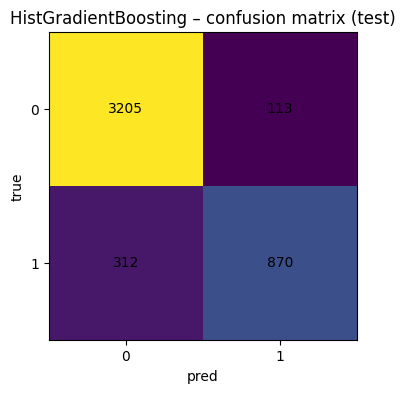

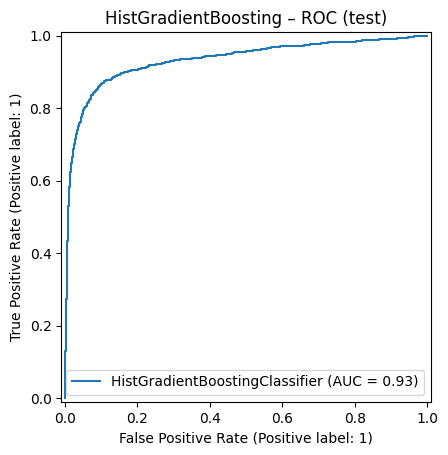

In [71]:
y_pred = best_model.predict(X_test)
plot_confusion(y_test, y_pred, title=f"{best_label} – confusion matrix (test)")
plot_roc(best_model, X_test, y_test, title=f"{best_label} – ROC (test)")

In [41]:
model_path = ARTIFACTS_DIR / "best_model.joblib"
joblib.dump(best_model, model_path)

meta = {
    "best_model_label": best_label,
    "test_metrics": best_row.to_dict(),
    "search_summary": search_summaries.get(best_label, None),
    "random_state": RANDOM_STATE,
}
save_json(meta, ARTIFACTS_DIR / "best_model_meta.json")

print("Saved:", model_path)
print("Saved:", ARTIFACTS_DIR / "best_model_meta.json")

Saved: artifacts\best_model.joblib
Saved: artifacts\best_model_meta.json


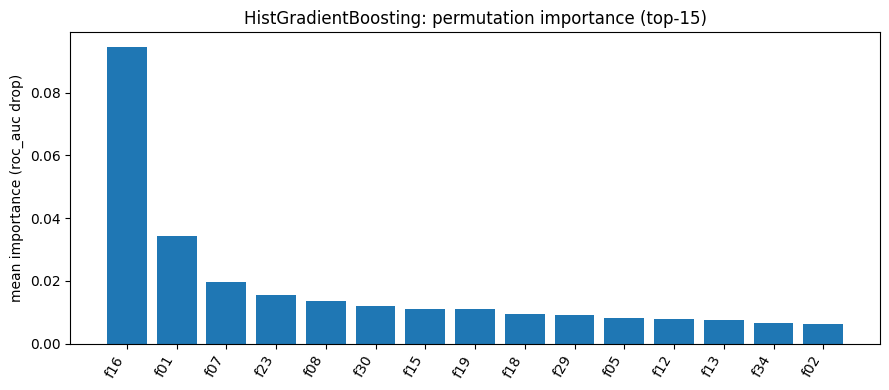

In [73]:
scoring = "roc_auc" if hasattr(best_model, "predict_proba") else "accuracy"

perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=8,
    random_state=RANDOM_STATE,
    scoring=scoring
)

imp = perm.importances_mean
idx = np.argsort(imp)[::-1][:15]

plt.figure(figsize=(9, 4))
plt.bar(range(len(idx)), imp[idx])
plt.xticks(range(len(idx)), [feature_names[i] for i in idx], rotation=60, ha="right")
plt.ylabel(f"mean importance ({scoring} drop)")
plt.title(f"{best_label}: permutation importance (top-15)")
plt.tight_layout()
plt.savefig(f"{ARTIFACTS_DIR}/figures/{best_label}_permutation_importance_(top-15).png")
plt.show()